In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/home/data/simon/processed/test_areas/ribe_new/flood"
figure_folder = "/home/data/simon/result/HSBA_loss2/HSBA_ribe"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];


In [3]:
threshold_indx = 3

3

## VV

In [4]:
co = VV[1][end:-1:1,:]
pre = VV[2][end:-1:1,:];

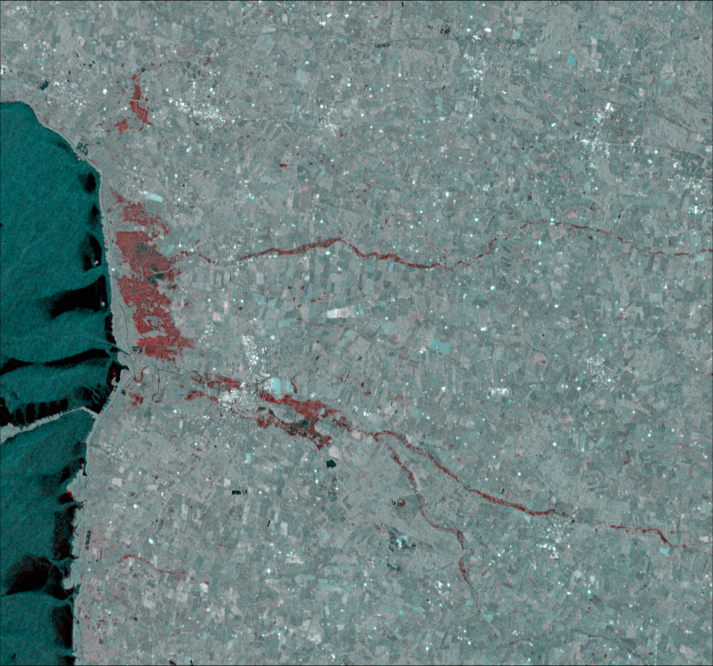

In [5]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [6]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [7]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


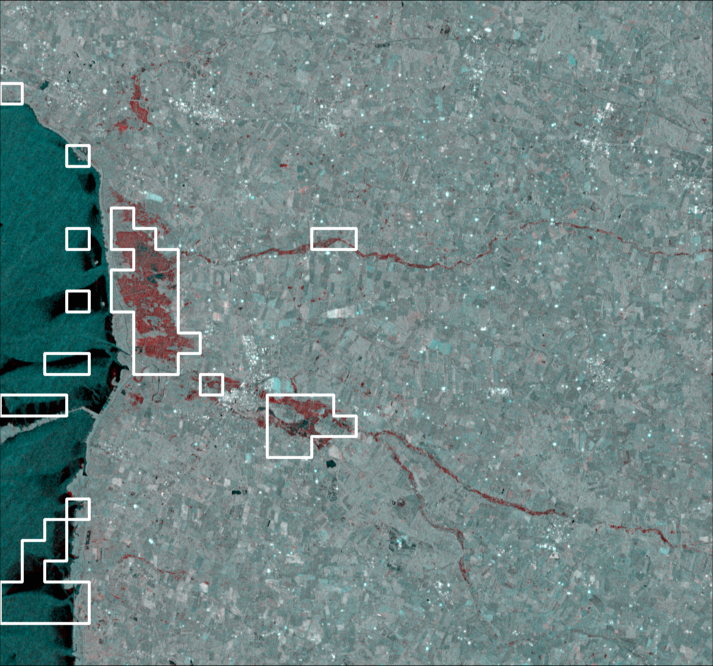

In [8]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVV,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VV_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [9]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;
y_seed

-13.65

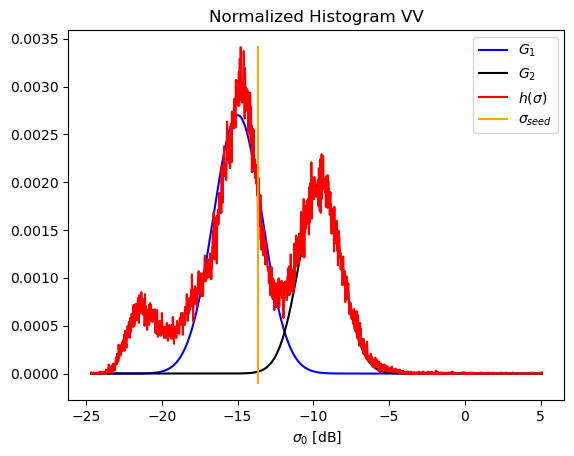

In [10]:
file_path = joinpath(figure_folder,"VV_histogram_tiles.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

In [11]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, thresholds1)
thresholds1, f1

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()


([-12.945312499999982, -0.009179687500000228], 0.0003645156137706497)

In [12]:
rg_thresholds = thresholds1

2-element Array{Float64,1}:
 -12.945312499999982   
  -0.009179687500000228

In [13]:
test_sigma = collect(LinRange(y_seed,-10,20))
test_dsigma = collect(LinRange(-3,3,20))
@time loss = [sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_gr

In [14]:
minimum(loss),maximum(loss)

(0.0003646730340797644, 0.0009472228275786207)

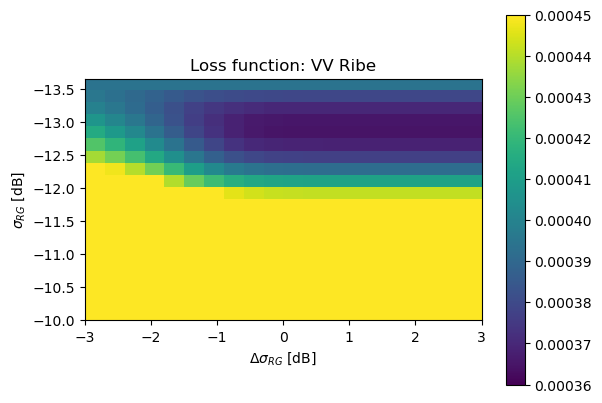

In [20]:
file_path = joinpath(figure_folder,"VV_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.00036,vmax=0.00045
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VV Ribe")
PyPlot.savefig(file_path)

In [21]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [22]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

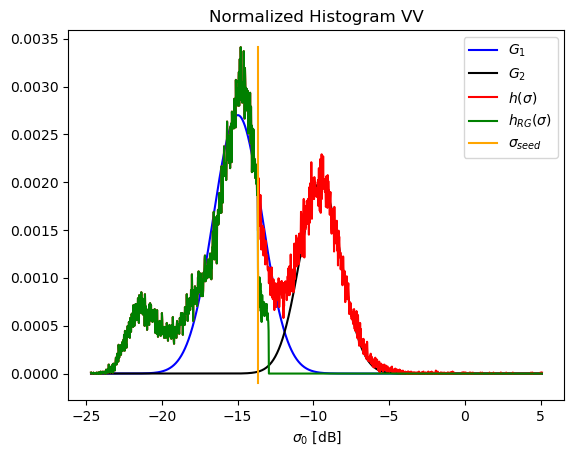

In [23]:
file_path = joinpath(figure_folder,"VV_histogram_flood.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

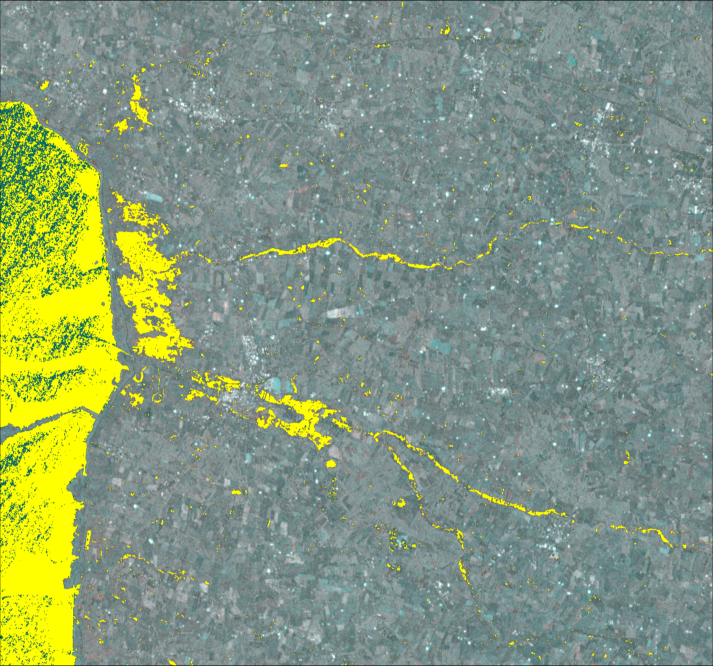

In [24]:
img_save = add_mask(imgVV,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VV_flood_noref")
FileIO.save(file_path*".png",img_save)
img_save

In [25]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

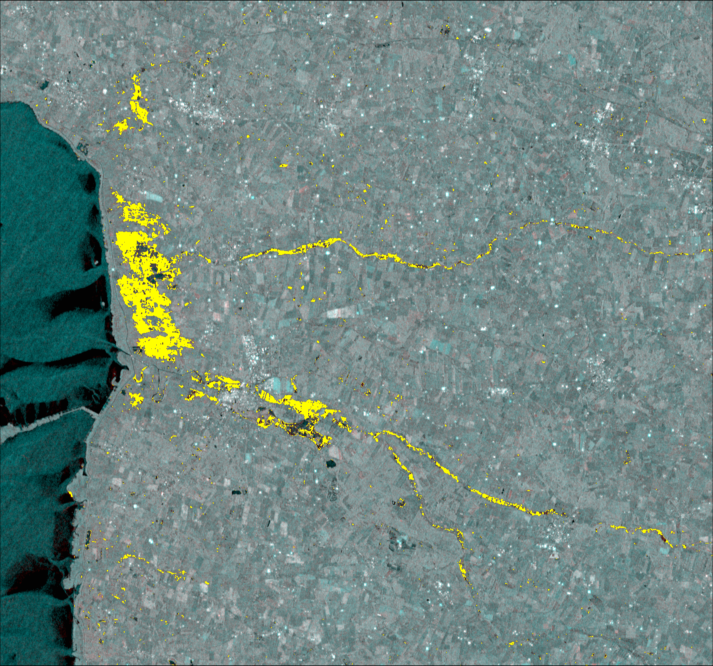

In [26]:
img_save = add_mask(imgVV,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VV_flood")
FileIO.save(file_path*".png",img_save)
img_save

In [27]:
file_path = joinpath(figure_folder,"VV_flood_mask")
JLD.save(file_path*".jld", "data", final_mask)

## VH

In [28]:
co = VH[1][end:-1:1,:]
pre = VH[2][end:-1:1,:];

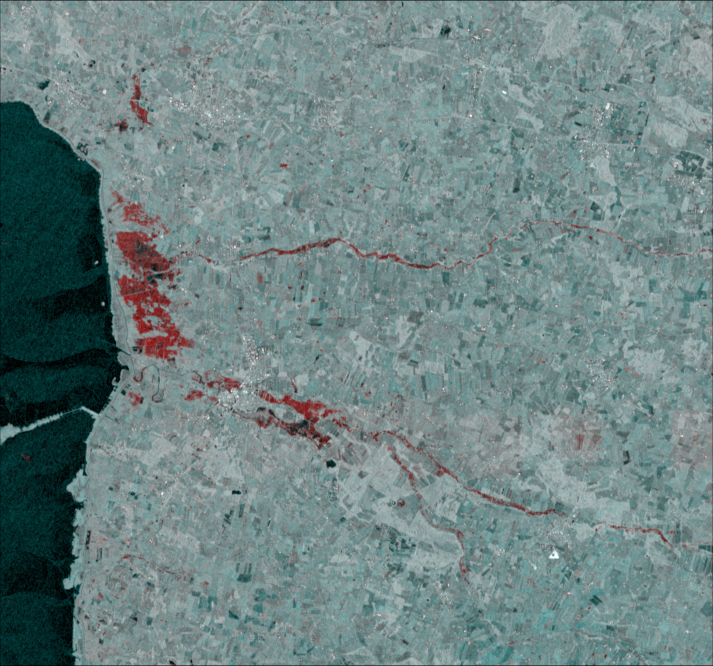

In [29]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [30]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [31]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


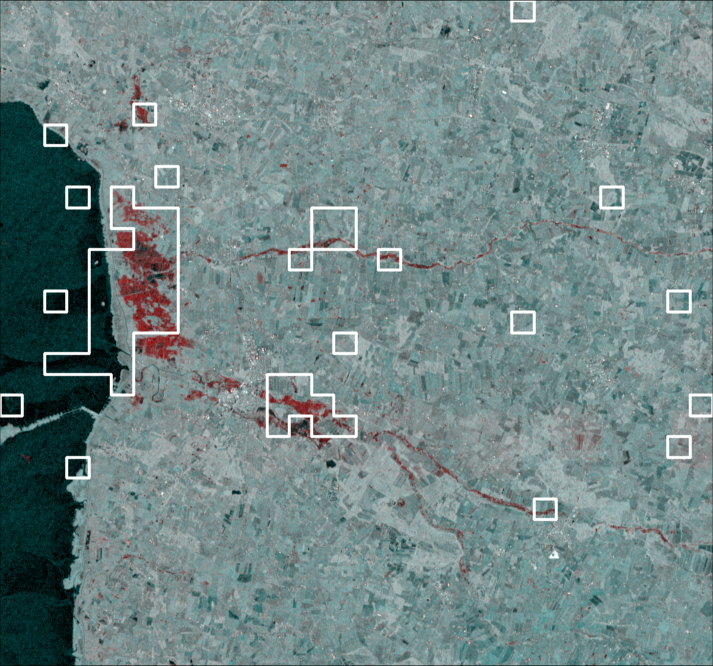

In [32]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVH,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VH_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [33]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;
y_seed

-22.41

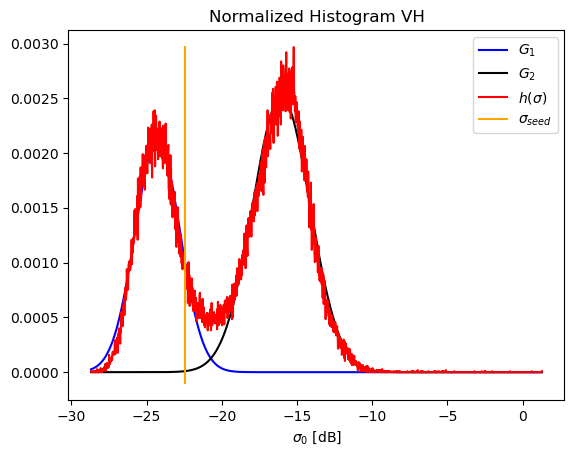

In [34]:
file_path = joinpath(figure_folder,"VH_histogram_tiles.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

In [35]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 =sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, thresholds1)
thresholds1, f1

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()


([-21.51234130859376, -0.8913825988769533], 0.00027143360179117127)

In [36]:
rg_thresholds = thresholds1

2-element Array{Float64,1}:
 -21.51234130859376  
  -0.8913825988769533

In [37]:
test_sigma = collect(LinRange(y_seed,-18,20))
test_dsigma = collect(LinRange(-3,3,20))
@time loss = [sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_gr

In [38]:
minimum(loss),maximum(loss)

(0.0002713647226287457, 0.00038450346305613577)

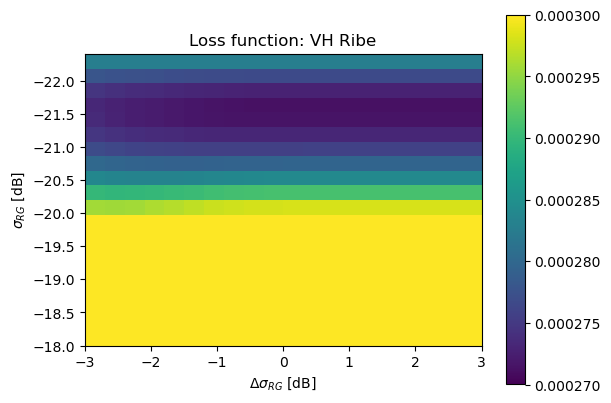

In [43]:
file_path = joinpath(figure_folder,"VH_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.00027,vmax=0.00030
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VH Ribe")
PyPlot.savefig(file_path)

In [44]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [45]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

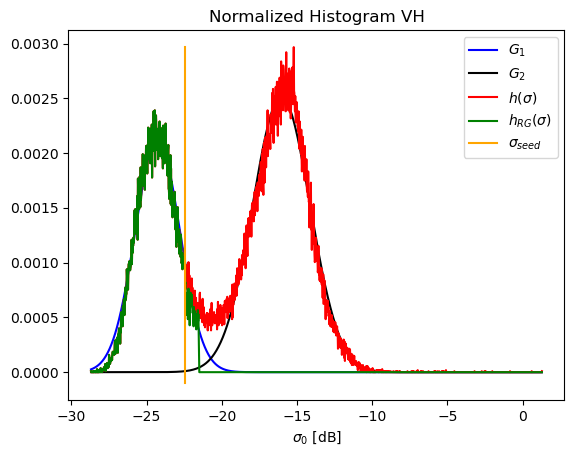

In [46]:
file_path = joinpath(figure_folder,"VH_histogram_flood.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

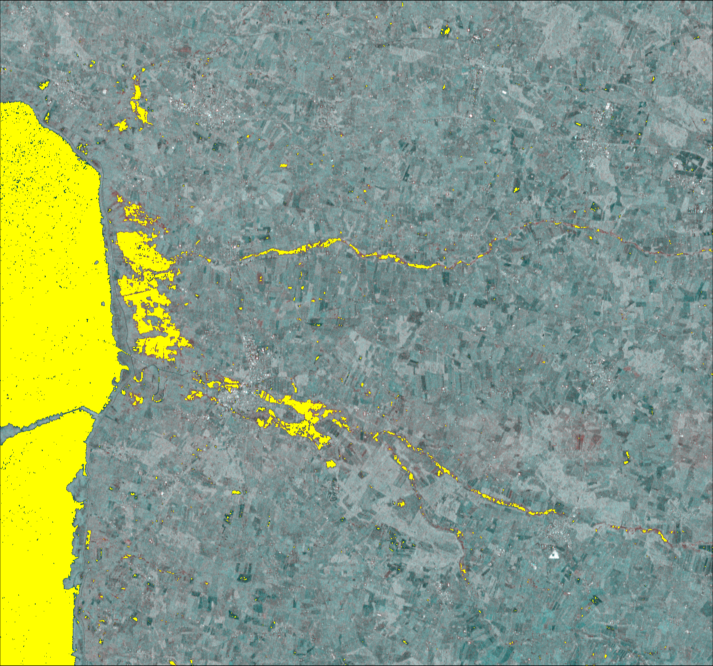

In [47]:
img_save = add_mask(imgVH,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VH_flood_noref")
FileIO.save(file_path*".png",img_save)
img_save

In [48]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

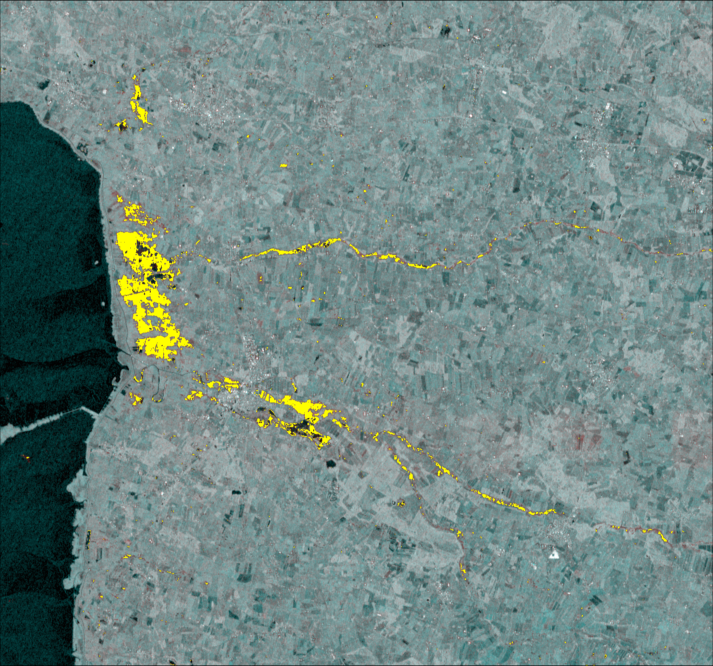

In [49]:
img_save = add_mask(imgVH,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VH_flood")
FileIO.save(file_path*".png",img_save)
img_save

In [50]:
file_path = joinpath(figure_folder,"VH_flood_mask")
JLD.save(file_path*".jld", "data", final_mask)